## Analysing the HSC reruns

Do the imports and set some matplotlib params

In [491]:
from lsst.daf.persistence import Butler
import astropy.table
import os, sys, time
import random
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import csv
import itertools
from collections import Counter
import treecorr
from astropy.io import ascii, fits
from diagnose import plot_XY
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import ipdb

In [492]:
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=False #True
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=False # True
matplotlib.rcParams['legend.fontsize']=14
matplotlib.rcParams['legend.numpoints']=1
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['legend.handlelength']=0.
matplotlib.rcParams['xtick.minor.visible']=True
matplotlib.rcParams['ytick.minor.visible']=True
matplotlib.rcParams['ytick.direction']='inout'
matplotlib.rcParams['xtick.direction']='inout'
if matplotlib.rcParams['xtick.direction']=='inout':
    matplotlib.rcParams['xtick.major.size']=2.*matplotlib.rcParams['xtick.major.size']
    matplotlib.rcParams['xtick.minor.size']=2.*matplotlib.rcParams['xtick.minor.size']
if matplotlib.rcParams['ytick.direction']=='inout':
    matplotlib.rcParams['ytick.major.size']=2.*matplotlib.rcParams['ytick.major.size']
    matplotlib.rcParams['ytick.minor.size']=2.*matplotlib.rcParams['ytick.minor.size']
matplotlib.rcParams['figure.subplot.bottom']=0.1
matplotlib.rcParams['figure.subplot.top']=0.95
matplotlib.rcParams['figure.subplot.right']=0.95
matplotlib.rcParams['figure.subplot.left']=0.095
matplotlib.rcParams['axes.labelsize']=18
matplotlib.rc('font',size=18)

The base plotting function

In [493]:
#from helper import plot_XY

def plot_XY(X_data,Y_data,weight_Y=None, bins=10, bins2=10, figax=None,label=None, color=None, side_histograms=True, normed=True):
    #ipdb.set_trace()
    if side_histograms is False:
        if figax is None:
            fig, ax = plt.subplots()
            figax = (fig,ax)
        else:
            fig,ax = figax
    else: ## side_histogram=True
        if figax is None:
            gs = matplotlib.gridspec.GridSpec(2,2,width_ratios=[3,1],height_ratios=[1,3],hspace=0.,wspace=0.)
            fig = plt.figure()
            fig.set_size_inches([12,8])
            ax = fig.add_subplot(gs[2])
            ax_top = fig.add_subplot(gs[0], sharex=ax)
            ax_right = fig.add_subplot(gs[3], sharey=ax)
            axes = [ax_top,None,ax,ax_right]
            figax = (fig, axes)
        else:
            fig, axes = figax
            ax_top, none, ax, ax_right = axes

    if isinstance(bins,int):
        nbins = bins
        binedges = np.nanpercentile(X_data,np.linspace(0,100,nbins+1))
    else:
        nbins = len(bins)-1
        binedges = bins
        
    if isinstance(bins2,int):
        nbins2 = bins2
        binedges2 = np.nanpercentile(Y_data, np.linspace(0,100,nbins2+1))
    else:
        nbins2 = len(bins2)-1
        binedges2 = bins2
        
    markers = {'g':'o','b':'s','c':'d','r':'^','m':'+','orange':'x'}

    X, Y, Yerr = [ ], [ ], [ ]
    for nbin in range(nbins):
        bincuts = (X_data>=binedges[nbin])&(X_data<binedges[nbin+1])

        x = np.average(X_data[bincuts])
        wtY = None if weight_Y is None else weight_Y[bincuts]
        #y = np.average(Y_data[bincuts],weights=wtY)
        y = np.nanmean(Y_data[bincuts])
        ## Question: How to compute errors on the weighted mean?
        yerr = Y_data[bincuts].std()/np.sqrt(bincuts.sum()-1)

        X.append(x)
        Y.append(y)
        Yerr.append(yerr)
    #print(X,Y,Yerr)
    mkr = markers[color] if color in markers.keys() else 'h'
    ax.errorbar(X,Y,yerr=Yerr,marker='.',label=label,color=color)
    
    if side_histograms is True:
        _ylim = ax.get_ylim()
        _xlim = ax.get_xlim()
        epsilon_x, epsilon_y = 1e-4, 1e-4
        _n, _bins, _patches = ax_top.hist(X_data,bins=binedges,histtype='step',density=normed, color=color)
        _n, _bins, _patches = ax_right.hist(Y_data,bins=binedges2,histtype='step', orientation='horizontal', density=normed, color=color)
        ax_right.tick_params(labelleft=False, labelright=True, right=True)
        ax_top.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True, top=True, right=True, left=False)

        ax_right.set_ylim(ax.get_ylim()[0]+epsilon_y,ax.get_ylim()[1])
        #ax_right.set_xlim(ax_right.get_xlim()[0]+epsilon_x,ax_right.get_xlim()[1])
        #ax_right.set_ylim(_ylim)
        
        #ax_top.set_xlim(_xlim)
        ax_top.set_xlim(ax_top.get_xlim()[0]+epsilon_x,ax_top.get_xlim()[1])
        #ax_top.set_ylim(ax_top.get_ylim()[0]+epsilon_y,ax_top.get_ylim()[1])

    return figax

Define convenience functions to calculate various sizes

In [494]:
def computeTraceRadius(cat):
    return np.sqrt(0.5*(cat.base_SdssShape_xx + cat.base_SdssShape_yy))

def computePsfTraceRadius(cat):
    return np.sqrt(0.5*(cat.base_SdssShape_psf_xx + cat.base_SdssShape_psf_yy))

def computeSigma(cat):
    return (cat.base_SdssShape_xx*cat.base_SdssShape_yy - cat.base_SdssShape_xy**2)**2

def computePsfSigma(cat):
    return (cat.base_SdssShape_psf_xx*cat.base_SdssShape_psf_yy - cat.base_SdssShape_psf_xy**2)**2

In [495]:
renaming = {('meas', 'HSC-I', 'calib_psf_used') : "calib_psf_used",
            ('meas', 'HSC-I', 'base_ClassificationExtendedness_value') : "base_ClassificationExtendedness_value",
            ('meas', 'HSC-I', 'base_SdssShape_psf_xx') : "base_SdssShape_psf_xx",
            ('meas', 'HSC-I', 'base_SdssShape_psf_yy') : "base_SdssShape_psf_yy",
            ('meas', 'HSC-I', 'base_SdssShape_psf_xy') : "base_SdssShape_psf_xy",
            ('meas', 'HSC-I', 'base_SdssShape_xx') : "base_SdssShape_xx",
            ('meas', 'HSC-I', 'base_SdssShape_yy') : "base_SdssShape_yy",
            ('meas', 'HSC-I', 'base_SdssShape_xy') : "base_SdssShape_xy",
            ('meas', 'HSC-I', 'coord_ra') : "coord_ra",
            ('meas', 'HSC-I', 'coord_dec') : "coord_dec",
            ('meas', 'HSC-I', 'tractId') : "tractId",
            ('meas', 'HSC-I', 'patchId') : "patchId",}

columns = ['coord_ra', 'coord_dec','iExtendedness','iCalib_psf_used', 'iCalib_psf_reserved', 'iCalib_psf_candidate', 'iIxx', 'iIyy', 'iIxy', 'iIxxPsf', 'iIyyPsf', 'iIxyPsf' ]

Some boilerplate code to fetch catalogs, since the postprocessing steps do not work as they should.

In [496]:
def getStarCatalog(order, tracts=range(9694,9701+1), patches=None):
    t1 = time.time()
    if patches is None:
        patches = ['{},{}'.format(i,j) for i,j in list(itertools.product(range(9),range(9)))]
    good_data_list = []
    butler = Butler('/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L{0}'.format(order))
    for _tract in tracts:
        for _patch in patches:
            #pathname = '/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L{0}/deepCoadd-results/merged/{1}/{2}/obj-{1}-{2}.parq'.format(order, _tract, _patch)
            #data = pd.read_parquet(pathname, 
            parq = butler.get('deepCoadd_obj', tract=_tract, patch=_patch, filter='HSC-I')
            data = parq.toDataFrame(columns=renaming.keys())
            good = data['base_ClassificationExtendedness_value']<0.5
            #bad |= (data['base_ClassificationExtendedness_value'] >= 0.5)
            good_data = data[good].copy(deep=True)
            good_data_list.append(good_data)

    good_data = pd.concat(good_data_list)
    t2 = time.time()
    print("Generated star catalogue in %.2f seconds" % (t2-t1))
    return good_data

def getYStarCatalog(order, tracts=range(9694,9701+1), columns=None):
    t1 = time.time()
    all_patches = ['{},{}'.format(i,j) for i,j in list(itertools.product(range(9),range(9)))]
    if columns is None:
        columns = ['iExtendedness','iCalib_psf_used', 'iCalib_psf_reserved', 'iCalib_psf_candidate', 'iIxx', 'iIyy', 'iIxy', 'iIxxPsf', 'iIyyPsf', 'iIxyPsf' ]
    good_data_list = []
    butler = Butler('/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L{0}'.format(order))
    for _tract in tracts:
        for _patch in all_patches:
            pathname = '/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L{0}/deepCoadd-results/merged/{1}/objectTable-{1}.parq'
            #parq = butler.get('objectTable', tract=9696, patch='5,5', filter='HSC-I')
            parq = butler.get('objectTable', tract=_tract, patch=_patch)
            df = parq.toDataFrame(columns=columns)
            good_data = df[df['iExtendedness']<0.5].dropna()
            print(_tract, _patch, good_data.shape)
            good_data_list.append( good_data )
        
    ret = pd.concat(good_data_list)
    t2 = time.time()
    print("Generated star catalogue in %.2f seconds" % (t2-t1))
    return ret
        
def getMatchedStarCatalog(orders=[5,7], tracts=range(9694,9701+1), patches=None, columns=None, distance_ratio=2):
    t1 = time.time()
    if patches is None:
        patches = ['{},{}'.format(i,j) for i,j in list(itertools.product(range(9),range(9)))]
    if columns is None:
        columns = ['iExtendedness','iCalib_psf_used', 'iCalib_psf_reserved', 'iCalib_psf_candidate', 'iIxx', 'iIyy', 'iIxy', 'iIxxPsf', 'iIyyPsf', 'iIxyPsf' ]
    good_data_list = []
    
    butlers = dict.fromkeys(orders)
    smallDict = dict.fromkeys(orders)
    retDict = {order:[] for order in orders}
    
    
    for order in orders:
        butlers[order] = Butler('/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L{0}'.format(order))
        
    n_obj = 0    
    for _tract in tracts:
        for _patch in patches:
            for order in orders:
                parq = butlers[order].get('deepCoadd_obj', tract=_tract, patch=_patch, filter='HSC-I')
                data = parq.toDataFrame(columns=renaming.keys())
                good = data['base_ClassificationExtendedness_value']<0.5
                smallDict[order] = data[good].copy(deep=True)
              
            ## Reference is the last order in the list
            order = orders[-1]
            tree = cKDTree(np.stack([smallDict[order].coord_ra, smallDict[order].coord_dec]).T)
            
            ## Query is done with the first order in the list
            order = orders[0]
            distances, indices = tree.query(np.stack([smallDict[order].coord_ra, smallDict[order].coord_dec]).T, k=2)
            
            cntr = Counter(indices[:,0])
            cntr_array = np.array([cntr[_idx] for _idx in indices[:,0]])
            left = smallDict[orders[0]] ## query
            right = smallDict[orders[-1]] ## reference
            
            right_indices = right.index[indices[(cntr_array==1)&(distances[:,1]/distances[:,0]>distance_ratio),0]].tolist()
            left_indices = left.index[(cntr_array==1)&(distances[:,1]/distances[:,0]>distance_ratio)].tolist()
            
            assert len(left_indices)==len(right_indices)
            n_obj += len(left_indices)
            retDict[orders[0]].append( left.loc[left_indices] )
            retDict[orders[-1]].append( right.loc[right_indices] )
       
    for order in orders:
        retDict[order] = pd.concat(retDict[order])
        assert retDict[order].shape[0]==n_obj
        
    return retDict

In [425]:
butler = Butler('/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L7')

#pathname = '/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L{0}/deepCoadd-results/merged/{1}/{2}/obj-{1}-{2}.parq'.format(order, _tract, _patch)
#data = pd.read_parquet(pathname, 
parq = butler.get('deepCoadd_obj', tract=9696, patch='8,7', filter='HSC-I')
cat = parq.toDataFrame()
all_colnames = list(cat.columns)

In [381]:
testMatch = getMatchedStarCatalog()
testMatch[5]

column,calib_psf_used,base_ClassificationExtendedness_value,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,coord_ra,coord_dec,tractId,patchId
id,,,,,,,,,,,,
42634662878642218,True,0.0,2.667920,2.772151,-0.016395,2.606337,2.756481,-0.031267,5.829161,-0.001656,9694,"0,0"
42634662878642221,False,0.0,2.668885,2.772488,-0.017090,2.586797,2.625478,-0.041522,5.829245,-0.001655,9694,"0,0"
42634662878642240,True,0.0,2.668727,2.772247,-0.016935,2.781034,2.831871,0.059439,5.829224,-0.001646,9694,"0,0"
42634662878642242,True,0.0,2.667819,2.771114,-0.019571,2.673204,2.783018,-0.015510,5.829447,-0.001636,9694,"0,0"
42634662878642244,False,0.0,2.481142,2.678656,-0.069435,1.575575,2.910101,-0.881899,5.832245,-0.001648,9694,"0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...
42666583075607567,False,0.0,1.588437,1.514199,0.092007,1.574779,0.843123,0.160911,5.985367,0.027573,9701,"8,8"
42666583075607585,True,0.0,1.553617,1.446009,0.094333,1.572456,1.449860,0.104554,5.985819,0.027597,9701,"8,8"
42666583075607586,False,0.0,1.552702,1.445472,0.093878,0.996664,1.318525,0.300947,5.985832,0.027600,9701,"8,8"


In [483]:
cat1 = testMatch[5][testMatch[5].calib_psf_used]
cat2 = testMatch[7][testMatch[7].calib_psf_used]
dTraceSize = computeTraceRadius(cat1)/computeTraceRadius(cat2) - 1
dPsfTraceSize = computePsfTraceRadius(cat1)/computePsfTraceRadius(cat2) -1
dSigma = computeSigma(cat1)/computeSigma(cat2) - 1
dPsfSigma = computePsfSigma(cat1)/computePsfSigma(cat2) - 1

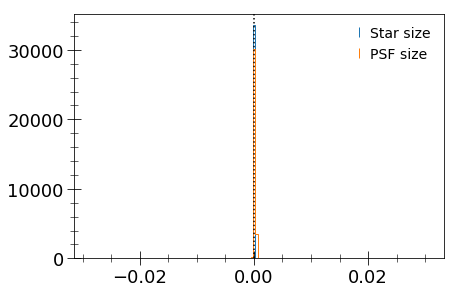

In [408]:
bins = np.arange(np.nanpercentile(dTraceSize,1), np.nanpercentile(dTraceSize,99), 0.0004)
plt.hist(dTraceSize, histtype='step', bins=bins, label='Star size')
bins = np.arange(np.nanpercentile(dPsfTraceSize,1), np.nanpercentile(dPsfTraceSize,99), 0.0004)
plt.hist(dPsfTraceSize, histtype='step', bins=bins, label='PSF size')
plt.legend(loc='best')
plt.axvline(0.0, color='k',ls=':')
#plt.yscale('log')


In [405]:
np.nanmean(dTraceSize), np.nanpercentile(dTraceSize,50), np.nanstd(dTraceSize)/np.sqrt(np.sum(~np.isnan(dTraceSize))), np.nanmean(dPsfTraceSize), np.nanpercentile(dPsfTraceSize,50), np.nanstd(dPsfTraceSize)/np.sqrt(np.sum(~np.isnan(dPsfTraceSize)))

(2.3103506929403086e-05,
 -4.2156977908547333e-10,
 4.409161875787384e-05,
 0.00011703032761468626,
 5.0255333579274364e-05,
 4.14372638760967e-05)

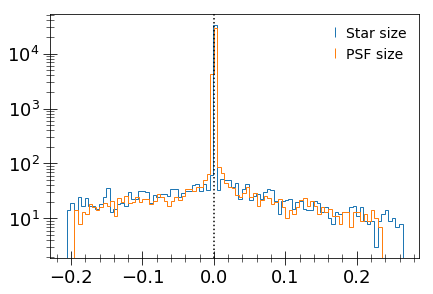

In [413]:
bins = np.arange(np.nanpercentile(dSigma,1), np.nanpercentile(dSigma,99), 0.005)
plt.hist(dSigma, histtype='step', bins=bins, label='Star size')
bins = np.arange(np.nanpercentile(dPsfSigma,1), np.nanpercentile(dPsfSigma,99), 0.005)
plt.hist(dPsfSigma, histtype='step', bins=bins, label='PSF size')
plt.legend(loc='best')
plt.axvline(0.0, color='k',ls=':')
plt.yscale('log')

In [8]:
starCatalog = getStarCatalog(3)
#starCatalog.rename(columns=renaming, inplace=True)
print(starCatalog.shape)

Generated star catalogue in 133.49 seconds
(1157863, 10)


In [45]:
smallDict = {3:None, 5:None, 7:None}
for order in [3,5,7]:
    smallDict[order] = getStarCatalog(order,tracts=[9696], patches=['4,4'])

Generated star catalogue in 6.78 seconds
Generated star catalogue in 3.64 seconds
Generated star catalogue in 4.65 seconds


In [506]:
orders = [3,5,7]
#starDict = dict.fromkeys(orders)
#starDict[3] = starCatalog
for order in orders:
    starDict[order] = getStarCatalog(order)

Generated star catalogue in 169.94 seconds
Generated star catalogue in 158.15 seconds
Generated star catalogue in 171.80 seconds


In [508]:
starDict[7]

column,calib_psf_used,base_ClassificationExtendedness_value,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,coord_ra,coord_dec,tractId,patchId
id,,,,,,,,,,,,
42634662878642218,True,0.0,2.666636,2.770200,-0.016497,2.606347,2.756492,-0.031267,5.829161,-0.001656,9694,"0,0"
42634662878642221,False,0.0,2.667581,2.770541,-0.017189,2.586805,2.625485,-0.041522,5.829245,-0.001655,9694,"0,0"
42634662878642226,True,0.0,2.666050,2.769104,-0.020293,2.615643,2.801745,0.002370,5.829518,-0.001653,9694,"0,0"
42634662878642240,True,0.0,2.667428,2.770301,-0.017035,2.781038,2.831875,0.059439,5.829224,-0.001646,9694,"0,0"
42634662878642242,True,0.0,2.666478,2.769180,-0.019661,2.673199,2.783013,-0.015510,5.829447,-0.001636,9694,"0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...
42666583075607560,True,0.0,1.553697,1.446104,0.094366,1.572453,1.449857,0.104553,5.985819,0.027597,9701,"8,8"
42666583075607561,False,0.0,1.552783,1.445566,0.093912,0.996652,1.318387,0.300889,5.985832,0.027600,9701,"8,8"
42666583075607563,False,0.0,1.576645,1.487613,0.082962,1.337686,0.565382,0.327921,5.985535,0.027596,9701,"8,8"


In [434]:
parq = butler.get('objectTable', tract=9699, patch='4,4', filter='HSC-I')
df = parq.toDataFrame()
all_columns = list(df.columns)
new_df = df[df['iExtendedness']<0.5].dropna()
print(new_df)

Empty DataFrame
Columns: [refFwhm, detect_isPatchInner, xErr, refBand, refIxxPsf, izStd, objectId, calib_psf_used, yErr, zyStd, detect_isPrimary, refIxyPsf, xy_flag, tractId, parentObjectId, refIyy, coord_ra, refIyyPsf, grStd, refIxy, coord_dec, refExtendedness, y, riStd, refIxx, patchId, x, detect_isTractInner, patch, tract, gRa, gDecl, gPsFlux, gPsFluxErr, gBdE1, gBdE2, gBdReB, gBdReD, gBdChi2, gBdFluxB, gBdFluxBErr, gBdFluxD, gBdFluxDErr, gIxx, gIyy, gIxy, gIxxPsf, gIyyPsf, gIxyPsf, gKronRad, gKronFlux, gKronFluxErr, gApFlux, gApFluxErr, gAp25Flux, gAp25FluxErr, gExtendedness, gBlendedness, gFwhm, gCModelFlux, gCModelFluxErr, gHsmShapeRegauss_e1, gHsmShapeRegauss_e2, gHsmShapeRegauss_flag, gInputCount, gDeblend_nChild, gBlendedness_flag, gPixelFlags, gPixelFlags_bad, gPixelFlags_bright_object, gPixelFlags_bright_objectCenter, gPixelFlags_clipped, gPixelFlags_clippedCenter, gPixelFlags_cr, gPixelFlags_crCenter, gPixelFlags_edge, gPixelFlags_inexact_psf, gPixelFlags_inexact_psfCenter,

In [379]:
for order in [3,5,7,77]:
    print(order, np.sum(starDict[order].calib_psf_used))

3 247269
5 246532
7 246479


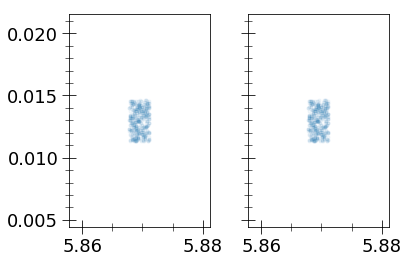

In [48]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
for idx, order in enumerate([5,7]):
    cuts = smallDict[order].calib_psf_used==True
    ax[idx].scatter(smallDict[order].coord_ra[cuts], smallDict[order].coord_dec[cuts], marker='.', alpha=0.05, label='L{}'.format(order))
#plt.legend()
dx, dy = 0.01, 0.001
fig.tight_layout()
#ax[0].set_xlim(5.9-dx,5.9+dx)
#ax[0].set_ylim(0.01-dy, 0.01+dy)

In [138]:
cuts = smallDict[7].calib_psf_used
tree = cKDTree(np.stack([smallDict[7].coord_ra[cuts], smallDict[7].coord_dec[cuts]]).T)

In [50]:
for order in [3,5,7]:
    print(order, smallDict[order].shape)

3 (1998, 12)
5 (1916, 12)
7 (1900, 12)


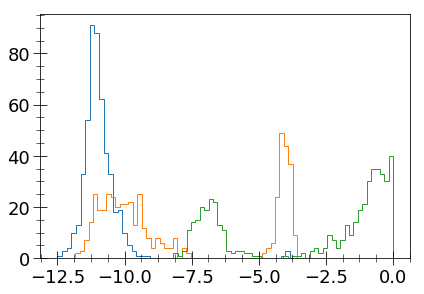

In [139]:
cuts5 = smallDict[5].calib_psf_used
distances, indices = tree.query(np.stack([smallDict[5].coord_ra[cuts5], smallDict[5].coord_dec[cuts5]]).T, k=2)
bins = 50
plt.hist(np.log10(distances[:,0]), histtype='step', bins=bins)
plt.hist(np.log10(distances[:,1]), histtype='step', bins=bins)
plt.hist(np.log10(distances[:,0])-np.log10(distances[:,1]), histtype='step', bins=bins)
dd = (distances[:,1])/distances[:,0]

In [376]:
cntr = Counter(indices[:,0])
cntr_array = np.array([cntr[_idx] for _idx in indices[:,0]])
left = smallDict[7][cuts]
right = smallDict[5][cuts5]
left_indices = left.index[indices[(cntr_array==1)&(distances[:,1]/distances[:,0]>2),0]].tolist()
right_indices = right.index[(cntr_array==1)&(distances[:,1]/distances[:,0]>2)].tolist()
#left.reset_index(inplace=True)
#right.reset_index(inplace=True)
#right['right_index'] = right.index
#right2 = right.loc[right_indices].reindex(left_indices)
print(right_indices[-5:], left_indices[-5:], cuts.sum(), cuts5.sum())
new_left = left.loc[left_indices].reset_index()
new_right = right.loc[right_indices].reset_index()
#mergedCat = pd.merge(new_left, new_right, left_on=list(range(410)), right_on=list(range(410)))
new_left

[42644025907372317, 42644025907372510, 42644025907372560, 42644025907372572, 42644025907372667] [42644025907372328, 42644025907372523, 42644025907372573, 42644025907372585, 42644025907372681] 492 495


column,id,calib_psf_used,base_ClassificationExtendedness_value,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,coord_ra,coord_dec,tractId,patchId
0,42644025907347536,True,0.0,1.899660,1.985162,-0.069312,1.879591,1.968174,-0.062988,5.867995,0.011308,9696,"4,4"
1,42644025907347577,True,0.0,1.868732,2.005422,-0.076348,1.856768,2.011255,-0.076420,5.868622,0.011327,9696,"4,4"
2,42644025907347605,True,0.0,1.941262,2.065953,-0.064539,1.937702,2.067703,-0.069295,5.869776,0.011337,9696,"4,4"
3,42644025907347618,True,0.0,1.953815,2.070025,-0.065512,1.958272,2.196894,-0.075576,5.870292,0.011337,9696,"4,4"
4,42644025907347619,True,0.0,1.932937,2.055176,-0.061312,1.976445,2.006888,-0.057381,5.868948,0.011313,9696,"4,4"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,42644025907372328,True,0.0,1.861905,2.006273,-0.073611,1.849210,1.987838,-0.073662,5.868622,0.014440,9696,"4,4"
406,42644025907372523,True,0.0,1.859910,2.000912,-0.072817,1.777957,1.925207,-0.087045,5.868634,0.014513,9696,"4,4"
407,42644025907372573,True,0.0,1.905049,2.039944,-0.062573,1.910639,2.048250,-0.059433,5.868222,0.014519,9696,"4,4"
408,42644025907372585,True,0.0,1.826928,1.990671,-0.075277,1.822390,1.974076,-0.071197,5.868273,0.014529,9696,"4,4"


In [377]:
pd.merge(new_left, new_right, left_index=True, right_index=True, suffixes=('_1','_2'))

column,id_1,calib_psf_used_1,base_ClassificationExtendedness_value_1,base_SdssShape_psf_xx_1,base_SdssShape_psf_yy_1,base_SdssShape_psf_xy_1,base_SdssShape_xx_1,base_SdssShape_yy_1,base_SdssShape_xy_1,coord_ra_1,...,base_SdssShape_psf_xx_2,base_SdssShape_psf_yy_2,base_SdssShape_psf_xy_2,base_SdssShape_xx_2,base_SdssShape_yy_2,base_SdssShape_xy_2,coord_ra_2,coord_dec_2,tractId_2,patchId_2
0,42644025907347536,True,0.0,1.899660,1.985162,-0.069312,1.879591,1.968174,-0.062988,5.867995,...,1.900175,1.985795,-0.069334,1.879593,1.968176,-0.062988,5.867995,0.011308,9696,"4,4"
1,42644025907347577,True,0.0,1.868732,2.005422,-0.076348,1.856768,2.011255,-0.076420,5.868622,...,1.869224,2.005908,-0.076359,1.856766,2.011253,-0.076420,5.868622,0.011327,9696,"4,4"
2,42644025907347605,True,0.0,1.941262,2.065953,-0.064539,1.937702,2.067703,-0.069295,5.869776,...,1.941908,2.066540,-0.064553,1.937698,2.067700,-0.069295,5.869776,0.011337,9696,"4,4"
3,42644025907347618,True,0.0,1.953815,2.070025,-0.065512,1.958272,2.196894,-0.075576,5.870292,...,1.954487,2.070616,-0.065521,1.958226,2.196838,-0.075576,5.870292,0.011337,9696,"4,4"
4,42644025907347619,True,0.0,1.932937,2.055176,-0.061312,1.976445,2.006888,-0.057381,5.868948,...,1.933555,2.055754,-0.061337,1.976417,2.006868,-0.057372,5.868948,0.011313,9696,"4,4"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,42644025907372328,True,0.0,1.861905,2.006273,-0.073611,1.849210,1.987838,-0.073662,5.868622,...,1.862524,2.006795,-0.073657,1.849204,1.987833,-0.073662,5.868622,0.014440,9696,"4,4"
406,42644025907372523,True,0.0,1.859910,2.000912,-0.072817,1.777957,1.925207,-0.087045,5.868634,...,1.860525,2.001421,-0.072864,1.777942,1.925197,-0.087047,5.868634,0.014513,9696,"4,4"
407,42644025907372573,True,0.0,1.905049,2.039944,-0.062573,1.910639,2.048250,-0.059433,5.868222,...,1.905739,2.040542,-0.062656,1.910637,2.048247,-0.059433,5.868222,0.014519,9696,"4,4"
408,42644025907372585,True,0.0,1.826928,1.990671,-0.075277,1.822390,1.974076,-0.071197,5.868273,...,1.828056,1.991228,-0.075441,1.822371,1.974049,-0.071184,5.868273,0.014529,9696,"4,4"


In [185]:
smallDict[5][cuts5].loc[right_indices]

column,calib_psf_used,base_ClassificationExtendedness_value,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,coord_ra,coord_dec,tractId,patchId
id,,,,,,,,,,,,
42644025907347535,True,0.0,1.900175,1.985795,-0.069334,1.879593,1.968176,-0.062988,5.867995,0.011308,9696,"4,4"
42644025907347576,True,0.0,1.869224,2.005908,-0.076359,1.856766,2.011253,-0.076420,5.868622,0.011327,9696,"4,4"
42644025907347604,True,0.0,1.941908,2.066540,-0.064553,1.937698,2.067700,-0.069295,5.869776,0.011337,9696,"4,4"
42644025907347617,True,0.0,1.954487,2.070616,-0.065521,1.958226,2.196838,-0.075576,5.870292,0.011337,9696,"4,4"
42644025907347618,True,0.0,1.933555,2.055754,-0.061337,1.976417,2.006868,-0.057372,5.868948,0.011313,9696,"4,4"
...,...,...,...,...,...,...,...,...,...,...,...,...
42644025907372317,True,0.0,1.862524,2.006795,-0.073657,1.849204,1.987833,-0.073662,5.868622,0.014440,9696,"4,4"
42644025907372510,True,0.0,1.860525,2.001421,-0.072864,1.777942,1.925197,-0.087047,5.868634,0.014513,9696,"4,4"
42644025907372560,True,0.0,1.905739,2.040542,-0.062656,1.910637,2.048247,-0.059433,5.868222,0.014519,9696,"4,4"


In [212]:
mergedCat[['right_index','coord_ra_x','coord_ra_y','coord_dec_x','coord_dec_y','base_SdssShape_psf_xx_x','base_SdssShape_psf_xx_y','base_SdssShape_psf_yy_x','base_SdssShape_psf_yy_y']].tail(10)

column,right_index,coord_ra_x,coord_ra_y,coord_dec_x,coord_dec_y,base_SdssShape_psf_xx_x,base_SdssShape_psf_xx_y,base_SdssShape_psf_yy_x,base_SdssShape_psf_yy_y
id,,,,,,,,,
42644025907356178,42644025907356178,5.868321,5.870805,0.014361,0.014363,1.996967,1.959604,2.031972,2.010015
42644025907367181,42644025907367181,5.868807,5.868856,0.011372,0.011348,1.850536,1.851142,1.970666,1.972175
42644025907367314,42644025907367314,5.869182,5.868253,0.011426,0.011427,1.931108,1.924177,2.050199,2.037738
42644025907368022,42644025907368022,5.869040,5.869928,0.011929,0.011932,1.946878,1.978793,2.047068,2.158794
42644025907370382,42644025907370382,5.869928,5.870920,0.013231,0.013212,1.911342,1.998772,2.154224,2.092428
42644025907371564,42644025907371564,5.867822,5.869627,0.013973,0.013987,1.958074,1.965862,2.139687,2.154596
42644025907371697,42644025907371697,5.869978,5.871078,0.014069,0.014065,1.946221,1.896934,2.127598,2.030419
42644025907371974,42644025907371974,5.869762,5.868305,0.014220,0.014228,1.917050,1.900301,2.037153,2.054682
42644025907372074,42644025907372074,5.868457,5.869364,0.014284,0.014282,1.823045,1.935522,1.998798,2.003007


In [228]:
mergedCat.reset_index?

Signature:
mergedCat.reset_index(
    level: Union[Hashable, Sequence[Hashable], NoneType] = None,
    drop: bool = False,
    inplace: bool = False,
    col_level: Hashable = 0,
    col_fill: Union[Hashable, NoneType] = '',
) -> Union[ForwardRef('DataFrame'), NoneType]
Docstring:
Reset the index, or a level of it.

Reset the index of the DataFrame, and use the default one instead.
If the DataFrame has a MultiIndex, this method can remove one or more
levels.

Parameters
----------
level : int, str, tuple, or list, default None
    Only remove the given levels from the index. Removes all levels by
    default.
drop : bool, default False
    Do not try to insert index into dataframe columns. This resets
    the index to the default integer index.
inplace : bool, default False
    Modify the DataFrame in place (do not create a new object).
col_level : int or str, default 0
    If the columns have multiple levels, determines which level the
    labels are inserted into. By default it is in

In [38]:
parq = butler.get("deepCoadd_obj", tract=9696, patch='4,4', filter='HSC-I')
df = parq.toDataFrame() #columns=renaming.keys())
#(df['base_ClassificationExtendedness_value']<0.5).sum()
print(df.meas['HSC-I'])

column             base_Blendedness_abs  base_Blendedness_abs_child_instFlux  \
id                                                                             
42644025907347457              0.000000                             2.691768   
42644025907347458              0.000000                             2.636250   
42644025907347459              0.000000                             8.534366   
42644025907347460              0.000000                          1905.081896   
42644025907347461              0.000000                             7.178596   
...                                 ...                                  ...   
42644025907372863              0.028182                             3.604959   
42644025907372864              0.005301                             7.284011   
42644025907372865              0.012044                             4.307990   
42644025907372866              0.012108                             4.375384   
42644025907372867              0.029838 

In [225]:
rand = getYStarCatalog(7, tracts=[9696])

Generated star catalogue in 5.99 seconds


In [211]:
[rand.iIxyPsf.isna().sum()]

0

In [227]:
Counter(rand['iCalib_psf_candidate'])

Counter({False: 93474, True: 36693})

In [223]:
rand.dropna?

Signature: rand.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
Docstring:
Remove missing values.

See the :ref:`User Guide <missing_data>` for more on which values are
considered missing, and how to work with missing data.

Parameters
----------
axis : {0 or 'index', 1 or 'columns'}, default 0
    Determine if rows or columns which contain missing values are
    removed.

    * 0, or 'index' : Drop rows which contain missing values.
    * 1, or 'columns' : Drop columns which contain missing value.

    .. versionchanged:: 1.0.0

       Pass tuple or list to drop on multiple axes.
       Only a single axis is allowed.

how : {'any', 'all'}, default 'any'
    Determine if row or column is removed from DataFrame, when we have
    at least one NA or all NA.

    * 'any' : If any NA values are present, drop that row or column.
    * 'all' : If all values are NA, drop that row or column.

thresh : int, optional
    Require that many non-NA values.
subset : array-like, opt

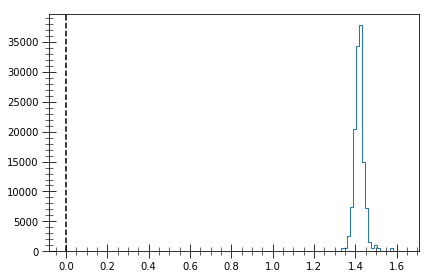

In [231]:
traceSize = np.sqrt(0.5*(rand.iIxx+rand.iIyy))
psfTraceSize = np.sqrt(0.5*(rand.iIxxPsf+rand.iIyyPsf))
#plt.hist(1.-traceSize/psfTraceSize, bins=np.linspace(-0.05,0.05,101), histtype='step')
plt.hist(psfTraceSize, bins=20, histtype='step')
plt.axvline(0.0, color='k', ls='--')

In [171]:
import parq
parq = parq.toDataFrame(columns={'column': ['calib_psf_used'], 'filter':'HSC-I', 'dataset':'meas'})

ModuleNotFoundError: No module named 'parq'

In [ ]:
p = butler.get('objectTable', tract=9696, patch="5,5", filter="HSC-I") p.toDataFrame(columns=['iPsFlux']).tail()``` p = butler.get('objectTable', tract=9696, patch="5,5") p.toDataFrame(columns=['iCalib_psf_used']).tail()

In [443]:
def addSuffix1(tup, suf):
    ret = (tup[0], tup[1], tup[2]+suf)
    return ret

def plotBob1(star_catalog, shape='SDSS', bins=10, bins2=10, label=None, figax=None, side_histograms=True):
    if shape=='HSM':
        column = 'ext_shapeHSM_HsmSourceMoments'
        psfColumn = 'ext_shapeHSM_HsmPsfMoments'
    else:
        column = ('forced_src', 'HSC-I', 'base_SdssShape')
        psfColumn =  ('forced_src', 'HSC-I', 'base_SdssShape_psf')
    #psfTraceSize = np.sqrt(0.5*(star_catalog[addSuffix1(psfColumn,'_xx')]+star_catalog[addSuffix1(psfColumn,'_yy')]))
    psfTraceSize = np.sqrt(0.5*(star_catalog['iIxxPsf']+star_catalog['iIyyPsf']))
    traceSize = np.sqrt(0.5*(star_catalog['iIxx']+star_catalog['iIyy']))
    diffTraceSize = 1.-traceSize/psfTraceSize
    psfFWHM = psfTraceSize*2.354820045*0.168
    print(diffTraceSize.mean())
    figax = plot_XY(X_data=psfFWHM, Y_data=diffTraceSize, bins=bins, bins2=bins2, figax=figax, label=label, side_histograms=side_histograms)
    return figax

def addSuffix2(tup, suf):
    return tup+suf

def plotBob2(star_catalog, shape='SDSS', bins=10, bins2=10, label=None, figax=None, side_histograms=True):
    if shape=='HSM':
        column = 'ext_shapeHSM_HsmSourceMoments'
        psfColumn = 'ext_shapeHSM_HsmPsfMoments'
    else:
        column = 'base_SdssShape'
        psfColumn =  'base_SdssShape_psf'
    psfTraceSize = np.sqrt(0.5*(star_catalog[addSuffix2(psfColumn,'_xx')]+star_catalog[addSuffix2(psfColumn,'_yy')]))
    traceSize = np.sqrt(0.5*(star_catalog[addSuffix2(column,'_xx')]+star_catalog[addSuffix2(column,'_yy')]))
    #psfTraceSize = np.sqrt(0.5*(star_catalog['iIxxPsf']+star_catalog['iIyyPsf']))
    #traceSize = np.sqrt(0.5*(star_catalog['iIxx']+star_catalog['iIyy']))
    diffTraceSize = 1.-traceSize/psfTraceSize
    psfFWHM = psfTraceSize*2.354820045*0.168
    print(diffTraceSize.mean())
    figax = plot_XY(X_data=psfFWHM, Y_data=diffTraceSize, bins=bins, bins2=bins2, figax=figax, label=label, side_histograms=side_histograms)
    return figax

0.0012424412750330423
0.00015857986896334638
8.003738674075389e-05
-5.9632561153701313e-05


Text(0.5, 0, 'FWHM (arcsec)')

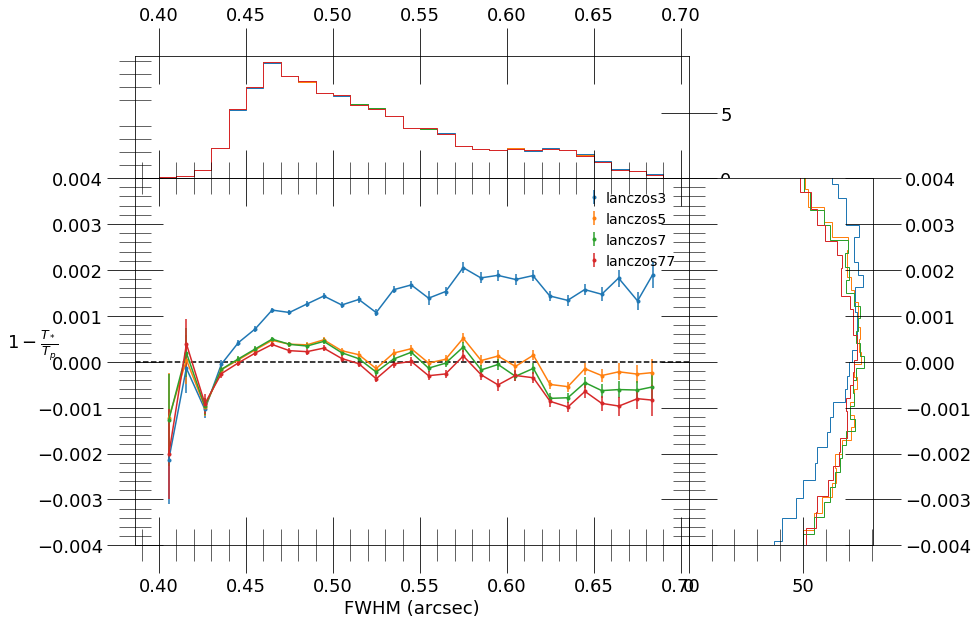

In [509]:
#starDict = {order: getStarCatalog(order=order) for order in [3,5,7]}

bins = np.arange(0.4,0.7,0.01)
bins2 = 50
figax = None
for order in [3,5,7,77]:
    cuts = starDict[order].calib_psf_used #base_ClassificationExtendedness_value==0
    figax = plotBob2(starDict[order][cuts], bins=bins, bins2=bins2, figax=figax, label='lanczos{}'.format(order))
fig,axes = figax
axes[2].axhline(0.0, color='k', ls='--')
axes[2].legend(loc='best')
axes[2].set_ylim(-0.004,0.004)
#axes[2].set_ylim(-0.4,0.4)
axes[2].set_ylabel(r"$1-\frac{T_*}{T_p}$", rotation=0)
axes[2].set_xlabel(r"FWHM (arcsec)")

(0, 13)


(0.014499999999999999, 0.0105)

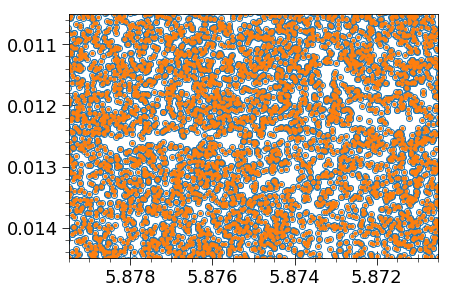

In [335]:
print(mergedCat.shape)
plt.plot(testMatch[5].coord_ra, testMatch[5].coord_dec, marker='o', ls='',fillstyle='none')
plt.plot(testMatch[7].coord_ra, testMatch[7].coord_dec, marker='.', ls='',)
dx, dy = 0.001/2, 0.001/2
plt.xlim(5.88-dx,5.87+dx)
plt.ylim(0.015-dy,0.01+dy)

In [484]:
print( " Mean dStarSize = ",np.nanmean(dSigma), "\n Median dStarSize = ", np.nanpercentile(dSigma,50), "\n SD dStarSize = ", np.nanstd(dSigma)/np.sqrt(np.sum(~np.isnan(dSigma))) )
print( "\n \n Mean dPsfSize = ", np.nanmean(dPsfSigma), "\n Median dPsfSize = ", np.nanpercentile(dPsfSigma,50), "\n SD dPsfSize = ", np.nanstd(dPsfSigma)/np.sqrt(np.sum(~np.isnan(dPsfSigma))))



 Mean dStarSize =  0.002189008818913455 
 Median dStarSize =  -1.557046491740266e-09 
 SD dStarSize =  0.0003801941905245511

 
 Mean dPsfSize =  0.00270072652450969 
 Median dPsfSize =  0.00039672822683378683 
 SD dPsfSize =  0.0003557043935715471


In [50]:
pathname = '/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L{0}/deepCoadd-results/merged/{1}/8,7/obj-{1}-8,7.parq'.format(5,9694)
data = pd.read_parquet(pathname)

In [34]:
butler = Butler('/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_L7/')

In [57]:
dataId = {'tract':9701, 'filter':'HSC-I', 'patch':'8,7'}
objCat = butler.get('deepCoadd_obj', **dataId).toDataFrame()

In [61]:
np.nanpe

Counter({False: 12599, True: 304})

In [132]:
np.sum(data[('meas', 'HSC-I', 'base_SdssShape_xx')].isna()), np.sum(data[('forced_src', 'HSC-I', 'base_SdssShape_xx')].isna())

(52, 52)

In [39]:
data.

[('forced_src', 'HSC-I', 'base_CircularApertureFlux_12_0_flag'),
 ('forced_src',
  'HSC-I',
  'base_CircularApertureFlux_12_0_flag_apertureTruncated'),
 ('forced_src',
  'HSC-I',
  'base_CircularApertureFlux_12_0_flag_sincCoeffsTruncated'),
 ('forced_src', 'HSC-I', 'base_CircularApertureFlux_12_0_instFlux'),
 ('forced_src', 'HSC-I', 'base_CircularApertureFlux_12_0_instFluxErr'),
 ('forced_src', 'HSC-I', 'base_CircularApertureFlux_17_0_flag'),
 ('forced_src',
  'HSC-I',
  'base_CircularApertureFlux_17_0_flag_apertureTruncated'),
 ('forced_src', 'HSC-I', 'base_CircularApertureFlux_17_0_instFlux'),
 ('forced_src', 'HSC-I', 'base_CircularApertureFlux_17_0_instFluxErr'),
 ('forced_src', 'HSC-I', 'base_CircularApertureFlux_25_0_flag'),
 ('forced_src',
  'HSC-I',
  'base_CircularApertureFlux_25_0_flag_apertureTruncated'),
 ('forced_src', 'HSC-I', 'base_CircularApertureFlux_25_0_instFlux'),
 ('forced_src', 'HSC-I', 'base_CircularApertureFlux_25_0_instFluxErr'),
 ('forced_src', 'HSC-I', 'base_C

In [423]:
%time
Nmax = 100000000
li1 = []
for iii in range(Nmax):
    li1.append(iii*2)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 14.8 µs


In [424]:
%time
Nmax = 100000000
li2 = [iii*2 for iii in range(Nmax)]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.8 µs


In [ ]:
set.sym